In [2]:
from net_metrics import *

model_def = 'models/bvlc_reference_caffenet_utkin/deploy_resnet.prototxt'
model_weights = 'models/bvlc_reference_caffenet_utkin/ResNet/caffenet_utkin_train_resNet_iter_250000.caffemodel'

cars, names = read_segments(filename=data_file)
net = init_net(model_def, model_weights)

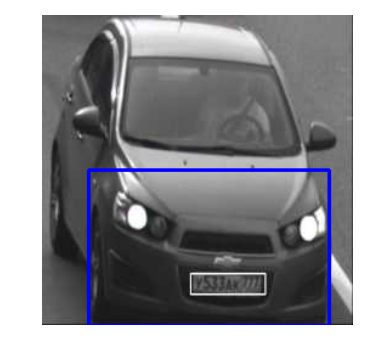

In [2]:
from os import path
import cv2

folder = 'searchProblem/'
for name in names:
    image = name[0]
    img = cv2.imread(path.join(folder, image))
    w, h, _ = img.shape
    start_x, start_y = w / 2 - 90, h / 2
    end_x, end_y = w - 20, h
    cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    break

In [15]:
def get_feature(src, layer='res5b', batch_size=1):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_raw_scale('data', 255)
    net.blobs['data'].reshape(batch_size, 1, 227, 227)
    net.blobs['data'].data[...] = np.transpose(transformer.preprocess('data', src), (2, 0, 1))
    out = net.forward()
    return net.blobs[layer].data[0].copy()

In [5]:
test_microsegments = [133, 134, 139, 141, 143, 144, 147, 148,
                      21, 22, 155, 156, 157, 160, 162, 163,
                      177, 168, 169, 171, 173, 175, 176, 49,
                      52, 55, 19, 20, 125, 126]

In [35]:
from os import path
import cv2
import skimage

folder = 'searchProblem/'
w, h = 256, 256
start_x, start_y = w / 2 - 90, h / 2
end_x, end_y = w - 20, h
distances = [0] * 512

counter = 0

for name in names:
    if name[1] in test_microsegments:
        continue
    image = name[0]
    img = skimage.img_as_float(skimage.io.imread(path.join(folder, image), as_grey=True)).astype(np.float32)
    img = img[:, :, np.newaxis]
    car_face = img[start_y:end_y, start_x:end_x]
    car_face = cv2.resize(car_face, (w, h))
    car_face = car_face[:, :, np.newaxis]
    img = get_feature(img)
    # plt.imshow(img[0])
    # plt.axis('off')
    # plt.show()
    car_face = get_feature(car_face)
    # plt.imshow(car_face[0])
    # plt.axis('off')
    # plt.show()
    for i in range(img.shape[0]):
        d = np.linalg.norm(img[i] - car_face[i])
        distances[i] += d
    counter += 1
    
distances = [d / counter for d in distances]
d = {'Distances': pd.Series(distances)}
df = pd.DataFrame(d)
cols = df.columns.tolist()
df = df[cols]
display(HTML(df.to_html()))

In [37]:
for i in range(5):
    print np.argmax(distances)
    distances[np.argmax(distances)] = 0

351
462
186
330
412


In [2]:
from net_metrics import *

model_def = 'models/bvlc_reference_caffenet_utkin/deploy_resnet.prototxt'
model_weights = 'models/bvlc_reference_caffenet_utkin/ResNet/caffenet_utkin_train_resNet_iter_250000.caffemodel'

cars, names = read_segments(filename=data_file)
net = init_net(model_def, model_weights)
features, labels = feature_extraction(net, 'res5b', names, chunk_size=10)

Started feature extraction...
Elapsed time: 81.0487749577


In [3]:
features = np.array(features)

In [4]:
print features[0].shape

(512, 8, 8)


In [38]:
maxs = [351, 462, 186, 330, 412]
mask = np.ones(features[0].shape, dtype=bool)
for pos in maxs:
    mask[pos] = False

In [20]:
temp = np.array(range(10))
mask = np.ones(temp.shape, dtype=bool)
mask[3] = False
print temp[mask]

[0 1 2 4 5 6 7 8 9]


In [39]:
feats = []

for i in range(len(features)):
    feats.append(features[i][mask])

In [40]:
len(feats[0])

32448

In [41]:
print len(feats[0])
print "product = ", 507 * 8 * 8

32448
product =  32448


In [42]:
feats = [feat.flatten() for feat in feats]

In [75]:
len(feats[1])

64

In [43]:
from net_metrics import *

_, times_imp, mapks10_imp, scores_imp = statistics_on_retrieve(cars, test_microsegments, names, feats)
# plot_mpks(test_microsegments, mapks)

Average score =  0.222444444444
Average map10 =  0.173387742504


In [10]:
_, times, mapks10, scores = statistics_on_retrieve(cars, test_microsegments, names, features)

Average score =  0.222777777778
Average map10 =  0.17317372134


In [51]:
len(mapks)

30

In [44]:
mapk10s = np.array(mapks10) - np.array(mapks10_imp)
scores = np.array(scores) - np.array(scores_imp)
mics = test_microsegments

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' 
    if  0 < val < 10: 
        color = 'green' 
    elif val > 10: 
        color = 'black'
    return 'color: %s' % color

d = {'Microsement': pd.Series(mics), 'Score': pd.Series(scores), 'MAP10': pd.Series(mapk10s)}
df = pd.DataFrame(d)
cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]
df = df.style.applymap(color_negative_red)
df
# display(HTML(df.to_html()))

In [1]:
from os import path
import cv2
import skimage
from skimage.draw import polygon

folder = 'searchProblem/'
features = []
for name in names:
    image = name[0]
    img = skimage.img_as_float(skimage.io.imread(path.join(folder, image), as_grey=True)).astype(np.float32)
    w, h = img.shape
    heat_map = np.zeros((w,h), dtype=np.uint8)
    # img = img[:, :, np.newaxis]
    size_x, size_y = 56, 56
    step = 10
    f = get_feature(img[:, :, np.newaxis], layer='fc1000')
    max_val = f[np.argmax(f)]
    for start_y in range(0, w - size_x + step, step):
        for start_x in range(0,h - size_y + step, step):
            end_x, end_y = start_x + size_x, start_y + size_y
            pic = img.copy()
            cv2.rectangle(pic, (start_y, start_x), (end_y, end_x), 1, -1)
            # plt.imshow(pic)
            # plt.show()
            # plt.imshow(pic[start_x:end_x + 10, start_y:end_y + 10])
            # plt.show()
            f_noised = get_feature(pic[:, :, np.newaxis], layer='fc1000')
            max_noised = f_noised[np.argmax(f)]
            if max_noised < max_val:
                addition = np.ones((size_x, size_y), dtype=np.uint8) * int( (max_val - max_noised) * 10)  
                # print addition.shape, heat_map[start_x:end_x, start_y:end_y].shape
                heat_map[start_x:end_x, start_y:end_y] = cv2.add(heat_map[start_x:end_x, start_y:end_y], addition)
            # print start_x, start_y
            # break
        # break
    values = np.unique(heat_map)
    border = (max(values) - min(values)) / 2
    start_x, end_x, start_y, end_y = w, 0, h, 0
    for i in range(w):
        for j in range(h):
            if heat_map[i, j] >= border:
                start_x = min(start_x, i)
                end_x = max(end_x, i)
                start_y = min(start_y, j)
                end_y = max(end_y, j)
    cv2.rectangle(heat_map, (start_y, start_x), (end_y, end_x), 255, 3)
    img = img[start_x:end_x, start_y:end_y]
    img = cv2.resize(img, (w, h))
    img = img[:, :, np.newaxis]
    features.append(get_feature(img))
    # fig = plt.figure(figsize=(10, 10))
    # a=fig.add_subplot(1,2,1)
    # imgplot = plt.imshow(img, cmap='gray')
    # plt.axis('off')
    # a.set_title('Origin')
    # a=fig.add_subplot(1,2,2)
    # imgplot = plt.imshow(heat_map)
    # plt.axis('off')
    # a.set_title('HeatMap')
    # plt.show()
print "Done."

ImportError: No module named cv2

In [ ]:
from net_metrics import *

feats = np.array(features)
_, times_imp, mapks10_imp, scores_imp = statistics_on_retrieve(cars, test_microsegments, names, feats)

In [64]:
net.blobs['data'].data.shape

(1, 1, 227, 227)

In [74]:
f[np.argmax(f)]

3.2003102

In [76]:
name

['6c10e40e-efbe-3661-25a3-cd00205abb12.jpg', 585]

In [93]:
j = 80
image = names[j][0]
img = skimage.img_as_float(skimage.io.imread(path.join(folder, image), as_grey=True)).astype(np.float32)  
f = get_feature(img[:, :, np.newaxis], layer='fc1000')
print np.argmax(f), names[j][1]
print f[np.argmax(f)]


54 585
2.47837


In [105]:
max_val - max_noised

-0.094082594